# Plot XG After Match

The goal of this notebook is to create a time plot that shows the XG and actual goals for each team over the course of the match, after the match has been completed.

It may be better to implement these visualizations on the frontend, but we can quickly prototype plots and return them as images from our server for completed matches on-demand.

In [1]:
%matplotlib inline

In [2]:
import sys
sys.path.append("../")

from haxml.prediction import (
    generate_rows_demo,
    predict_xg_demo
)
from haxml.utils import (
    get_stadiums,
    load_match,
)
import joblib
from matplotlib.figure import Figure
import matplotlib.pyplot as plt

In [3]:
MATCH = "-MOyZiwOkxMJwf-lNiT3"
STADIUM = "NAFL 1v1/2v2 Map v1"

In [4]:
model_name = "demo_logit"
demo_clf = joblib.load("../models/demo_logistic_regression.pkl")
stadiums = get_stadiums("../data/stadiums.json")

In [5]:
s = stadiums[STADIUM]
match = load_match(
    "../data/packed_matches/{}.json".format(MATCH),
    lambda m: predict_xg_demo(m, s, generate_rows_demo, demo_clf)
)

In [6]:
def get_xg_time_series(match):
    """
    Produces series for XG match time plot.
    Args:
        match: Inflated match data (dict).
    Returns:
        Tuple of (time, ags_red, ags_blue, xgs_red, xgs_blue).
    """
    time = []
    ags_red = []
    ags_blue = []
    xgs_red = []
    xgs_blue = []
    ag_red = 0
    ag_blue = 0
    xg_red = 0
    xg_blue = 0
    time.append(0)
    ags_red.append(ag_red)
    ags_blue.append(ag_blue)
    xgs_red.append(xg_red)
    xgs_blue.append(xg_blue)
    for kick in match["kicks"]:
        if kick["type"] == "goal":
            if kick["fromTeam"] == "red":
                ag_red += 1
            else:
                ag_blue += 1
        elif kick["type"] == "own_goal":
            if kick["team"] == "red":
                ag_blue += 1
            else:
                ag_red += 1
        if kick["fromTeam"] == "red":
            xg_red += kick["xg"]
        else:
            xg_blue += kick["xg"]
        time.append(kick["time"])
        ags_red.append(ag_red)
        ags_blue.append(ag_blue)
        xgs_red.append(xg_red)
        xgs_blue.append(xg_blue)
    time.append(match["score"]["time"])
    ags_red.append(ag_red)
    ags_blue.append(ag_blue)
    xgs_red.append(xg_red)
    xgs_blue.append(xg_blue)
    return (
        time,
        ags_red,
        ags_blue,
        xgs_red,
        xgs_blue
    )

In [7]:
def plot_xg_time_series(match):
    """
    Plots XG match time series for a match.
    Args:
        match: Inflated match data (dict).
    Returns:
        Tuple (fig, ax).
    """
    fig = Figure()
    ax = fig.add_subplot(1, 1, 1)
    xg_time_ser = get_xg_time_series(match)
    time, ags_red, ags_blue, xgs_red, xgs_blue = xg_time_ser
    ax.plot(time, ags_red, color="red", linestyle="-", label="Red Actual")
    ax.plot(time, xgs_red, color="red", linestyle="--", label="Red XG")
    ax.plot(time, ags_blue, color="blue", linestyle="-", label="Blue Actual")
    ax.plot(time, xgs_blue, color="blue", linestyle="--", label="Blue XG")
    title = "Final Score: {} Won {}-{}\n{}"
    red_score = match["score"]["red"]
    blue_score = match["score"]["blue"]
    winner = "Red" if red_score > blue_score else "Blue"
    stadium_name = match["stadium"]
    ax.set_title(title.format(winner, red_score, blue_score, stadium_name))
    ax.set_xlabel("Match Time (secs)")
    ax.set_ylabel("Goals")
    ax.legend()
    return fig, ax

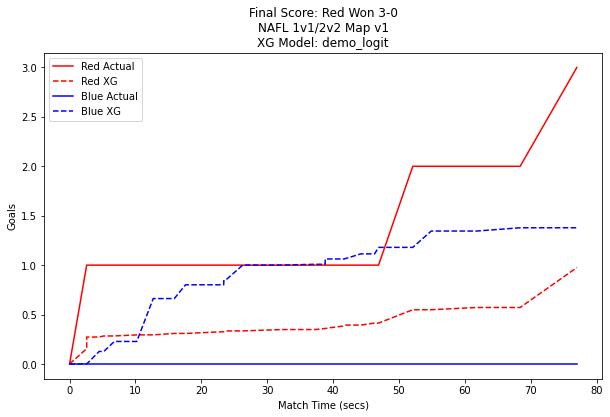

In [8]:
fig, ax = plot_xg_time_series(match)
ax.set_title("{}\nXG Model: {}".format(ax.title.get_text(), model_name))
fig.set_size_inches(10, 6)
fig